### Part 1: Implmenting DP-SGP with 2-d vector learning rate

Below is the converted DP-SGD Logistic Regression model from predicting employment with 3-d learning rate vector v (educ, disability, intercept) to predicting marital status with 2-d learning rate vector v (educ weight, intercept), implemented via optimizer parameter groups Opacus

Changes that I made in this model:
* Changed the prediction target to marital status and reduced the feature set to education level only
* Kept the DP-SGD Opacus mechanics (per-sample clipping and Gaussian noise) but applied to a 2-parameter model
* Implemented a 2-d learning rate vector (education coefficient and intercept)
* Tuned model parameters:
    * Gaussian noise = 0.85
    * Clipping bound = 0.6
* Validated utility (validation loss/accuracy) and (epsilon, delta) privacy report

I also put some comments for explanation in each step


/Users/winwin/Documents/School/CPP/CS5510/CS_5510/lib/python3.13/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/var/folders/p5/99nsw5616w96hnkzn2xcl3r80000gn/T/ipykernel_60115/3095615531.py:76: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Epoch 01 | Validation Loss = 1.609 | Validation Accuracy = 0.452
Epoch 02 | Validation Loss = 1.303 | Validation Accuracy = 0.452
Epoch 03 | Validation Loss = 1.067 | Validation Accuracy = 0.452
Epoch 04 | Validation Loss = 0.868 | Validation Accuracy = 0.452
Epoch 05 | Validation Loss = 0.741 | Validation Accuracy = 0.451
Epoch 06 | Validation Loss = 0.687 | Validation Accuracy = 0.548
Different Privacy budget: ε ≈ 2.6891 at δ=1e-6
Coefficients: education weight = 0.0100, intercept = 0.0597


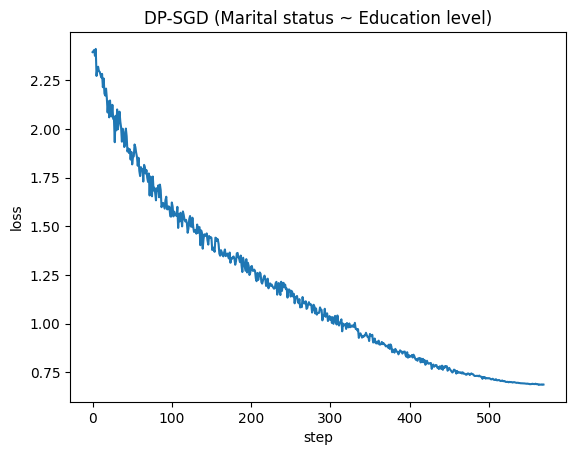

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import certifi, pandas as pd, numpy as np, ssl, urllib.request
from torch.utils.data import TensorDataset, DataLoader, random_split
from opacus import PrivacyEngine
import matplotlib.pyplot as plt

torch.manual_seed(123)

# Load data & build tensors 
URL = "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv"

# robust HTTPS fetch on macOS / strict SSL (as my local certs aren't allowed to access certifi bundle)
ctx = ssl.create_default_context(cafile=certifi.where())
with urllib.request.urlopen(URL, context=ctx) as resp:
    data = pd.read_csv(resp)

# marital status given education level: married ~ educ
X = torch.tensor(data[['educ']].values).float()
y = torch.tensor(data['married'].values).float()

dataset = TensorDataset(X, y)

# Data split: 80% train, 20% val
n = len(dataset)
n_tr = int(0.8 * n)
train_set, val_set = random_split(dataset, [n_tr, n - n_tr],
                                  generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=4096, shuffle=False)

# One-feature logistic regression (weight for educ + intercept)
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # bias = True gives the intercept

    def forward(self, x):
        return self.linear(x).squeeze(1)  # logits

model = LogisticRegression()

# 2-D learning-rate vector via param groups (educ weight vs intercept)
lr_w = 0.01   # for education coefficient
lr_b = 0.01   # for intercept (bias)
optimizer = torch.optim.SGD([
    {"params": model.linear.weight, "lr": lr_w},
    {"params": model.linear.bias,   "lr": lr_b},
])

# Make training differentially private (clipping + Gaussian noise) 
# DP-SGD via Opacus PrivacyEngine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=0.85,   # gaussian noise
    max_grad_norm=0.6,       # per-example clipping bound
)

# Loss (log-likelihood) Function with built-in sigmoid
criterion = nn.BCEWithLogitsLoss(reduction="mean")

# Train the model
epochs = 6
loss_trace = []
for epoch in range(1, epochs + 1):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_trace.append(loss.item())

    # Validation metrics
    model.eval()
    with torch.no_grad():
        vloss, correct, total = 0.0, 0, 0
        for xb, yb in val_loader:
            logits = model(xb)
            vloss += criterion(logits, yb).item() * yb.numel()
            preds = (torch.sigmoid(logits) >= 0.5).float()  # compute validation loss/accuracy
            correct += (preds == yb).sum().item()
            total   += yb.numel()
    print(f"Epoch {epoch:02d} | Validation Loss = {(vloss/total):.3f} | Validation Accuracy = {(correct/total):.3f}")

# Report privacy budget (δ)
eps = privacy_engine.get_epsilon(delta=1e-6)    # same δ as in class code
print(f"Different Privacy budget: ε ≈ {eps:.4f} at δ=1e-6")

# Inspect learned parameters
w = model.linear.weight.detach().cpu().numpy().ravel()[0]
b = model.linear.bias.detach().cpu().numpy().ravel()[0]
print(f"Coefficients: education weight = {w:.4f}, intercept = {b:.4f}")

# Plot training loss
plt.plot(loss_trace)
plt.xlabel("step"); plt.ylabel("loss"); plt.title("DP-SGD (Marital status ~ Education level)"); plt.show()


### Part 2: Private Model Selection

In this part, I trained multiple differentially private models (10 logistic regressions model for predicting marital status given education level) with different learning rates and then choose one model to release in a privacy-preserving way

What I did in this experiment:
* Each model is trained with DP-SGD at approximately epsilon = 1 and detal = 1e-6
* Experimented model parameters with different learning rate values:
    * epsilon = 1
    * delta = 1e-6
    * epochs = 5
    * clipping bound = 0.8
    * learning rate = [0.001 - 0.03]
* For model selection, I choose a model to release using the Exponential Mechanism with epsilon = 1, which uses negative validation loss as a score (We want a higher score, which means lower loss)

In [19]:
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from opacus import PrivacyEngine

torch.manual_seed(123)

# Data split. Data already loaded as dataset in the previous code cell
n = len(dataset)
n_tr = int(0.8 * n)
train_set, val_set = random_split(dataset, [n_tr, n - n_tr],
                                  generator=torch.Generator().manual_seed(0))
train_loader_base = DataLoader(train_set, batch_size=2048, shuffle=True)
val_loader        = DataLoader(val_set,   batch_size=4096, shuffle=False)
n_val = len(val_set)

# Logistic Regression Model 
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 1 feature + intercept for 2 params
    def forward(self, x):
        return self.linear(x).squeeze(1)  

# Training function: train ONE DP model to target (ε=1, δ=1e-6) 
def train_dp_model(lr_scalar, epochs=5, max_grad_norm=0.8, target_eps=1.0, target_delta=1e-6):
    model = LogisticRegression()
    # 2-D learning rate vector via param groups (weight vs bias both use lr_scalar)
    optimizer = torch.optim.SGD([
        {"params": model.linear.weight, "lr": lr_scalar},
        {"params": model.linear.bias,   "lr": lr_scalar},
    ])
    # We’ll calibrate noise automatically to hit target ε using Opacus
    privacy_engine = PrivacyEngine()
    # Use make_private_with_epsilon so each model is trained at ε=1, δ=1e-6 
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader_base,
        target_epsilon=target_eps,
        target_delta=target_delta,
        epochs=epochs,
        max_grad_norm=max_grad_norm,
    )

    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    # Return trained model + its privacy engine (if you want to re-check ε)
    return model, privacy_engine

# ---------- Score on validation with CLIPPED per-example loss ----------
# Score = negative average loss; sensitivity Δ = L_max / n_val
L_MAX = 5.0  # clips per-example BCE to [0, L_MAX] to bound sensitivity

def score_model(model):
    model.eval()
    per_ex_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            # per-example BCE (no reduction), then clip
            losses = F.binary_cross_entropy_with_logits(logits, yb, reduction="none")
            losses = torch.clamp(losses, max=L_MAX)
            per_ex_losses.append(losses)
    per_ex_losses = torch.cat(per_ex_losses)
    avg_loss = per_ex_losses.mean().item()
    score = -avg_loss  # higher is better which means lower loss is better
    return score, avg_loss

# ---------- Train 10 DP models across learning rates ----------
K = 10
# Reasonable Learning Rate grid (log-spaced). I picked the range around [0.001 .. 0.0316]
lr_grid = np.logspace(-3, -1.5, K)  
epochs = 5
max_grad_norm = 1.0
target_eps = 1.0
target_delta = 1e-6

models = []
scores = []
avg_losses = []
train_epsilons = []
for lr in lr_grid:
    m, pe = train_dp_model(float(lr), epochs=epochs,
                           max_grad_norm=max_grad_norm,
                           target_eps=target_eps, target_delta=target_delta)
    sc, al = score_model(m)
    eps_i = pe.get_epsilon(delta=target_delta)

    train_epsilons.append(eps_i)
    models.append((m, pe))
    scores.append(sc)
    avg_losses.append(al)
    print(f"Learning Rate = {lr:.5f} | Validation Avg Loss = {al:.4f} | Trained Epsilon = {eps_i:.3f} | Score = {sc:.4f}")

scores = np.array(scores)

# ---------- Exponential Mechanism (ε=1 for selection) ----------
# Sensitivity of average clipped loss: Δ = L_MAX / n_val
Delta = L_MAX / n_val
eps_select = 1.0

# probability ∝ exp( (ε * score) / (2Δ) )
logits = (eps_select * scores) / (2.0 * Delta)
# for numerical stability:
logits = logits - logits.max()
probs = np.exp(logits)
probs = probs / probs.sum()

# sample 1 index according to Exponential Mechanism
chosen_idx = np.random.choice(np.arange(K), p=probs)
chosen_lr  = lr_grid[chosen_idx]
chosen_model = models[chosen_idx][0]

# ---------- Report chosen model & parameters ----------
w = chosen_model.linear.weight.detach().cpu().numpy().ravel()[0]
b = chosen_model.linear.bias.detach().cpu().numpy().ravel()[0]
print("\n=== Private Model Selection ===")
print(f"Chosen model: model {chosen_idx}  |  LR = {chosen_lr:.6f}")
print(f"Selected model params: education weight = {w:.4f}, intercept = {b:.4f}")
print(f"Selected model validation loss = {avg_losses[chosen_idx]:.4f}")



/var/folders/p5/99nsw5616w96hnkzn2xcl3r80000gn/T/ipykernel_60115/2421353386.py:51: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Learning Rate = 0.00100 | Validation Avg Loss = 1.5271 | Trained Epsilon = 0.995 | Score = -1.5271
Learning Rate = 0.00147 | Validation Avg Loss = 1.1656 | Trained Epsilon = 0.995 | Score = -1.1656
Learning Rate = 0.00215 | Validation Avg Loss = 1.3024 | Trained Epsilon = 0.995 | Score = -1.3024
Learning Rate = 0.00316 | Validation Avg Loss = 0.7005 | Trained Epsilon = 0.995 | Score = -0.7005
Learning Rate = 0.00464 | Validation Avg Loss = 0.8504 | Trained Epsilon = 0.995 | Score = -0.8504
Learning Rate = 0.00681 | Validation Avg Loss = 1.0940 | Trained Epsilon = 0.995 | Score = -1.0940
Learning Rate = 0.01000 | Validation Avg Loss = 1.0882 | Trained Epsilon = 0.995 | Score = -1.0882
Learning Rate = 0.01468 | Validation Avg Loss = 1.1440 | Trained Epsilon = 0.995 | Score = -1.1440
Learning Rate = 0.02154 | Validation Avg Loss = 1.1407 | Trained Epsilon = 0.995 | Score = -1.1407
Learning Rate = 0.03162 | Validation Avg Loss = 1.1435 | Trained Epsilon = 0.995 | Score = -1.1435

=== Priva

**Result Report**

Among the 10 differntially private model, model 3 with the Learning Rate = 0.003162 yields the best validation loss

Below the Learning Rate vs Validation Loss plot for private model selection visualization



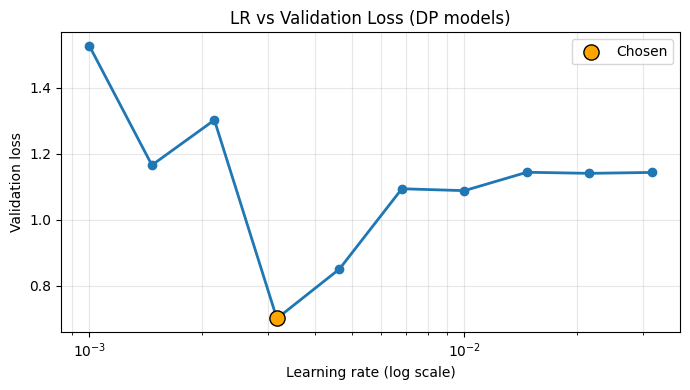

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Use what you already have
lr_arr   = np.array(lr_grid, dtype=float)
loss_arr = np.array(avg_losses, dtype=float)

fig, ax = plt.subplots(figsize=(7,4))
ax.semilogx(lr_arr, loss_arr, marker="o", linewidth=2)
ax.set_xlabel("Learning rate (log scale)")
ax.set_ylabel("Validation loss")
ax.set_title("LR vs Validation Loss (DP models)")
ax.grid(True, which="both", alpha=0.3)

# Optional: highlight the chosen model
try:
    ax.scatter(lr_arr[chosen_idx], loss_arr[chosen_idx], s=120, edgecolor="k", facecolor="orange", zorder=3, label="Chosen")
    ax.legend()
except NameError:
    pass

plt.tight_layout()
plt.show()


**Github:** https://github.com/tttrang152k/Data-Privacy-and-Security/tree/main/HW2